In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
import h5py
from SuperpixelCutsPy import *
# Configs for Notebooks
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(suppress=True)

In [2]:
# Load Dataset
dataset_name = 'samson'
h5_import = sp.io.loadmat("data/samson.mat")['V']
hyperspectral_cube = utility.matrix_to_cube(h5_import, 95, 95, 156).astype(float)
nx,ny,nb = hyperspectral_cube.shape

In [3]:
preprocessing_pipeline = Preprocesser.Preprocesser(data = hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 0)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()

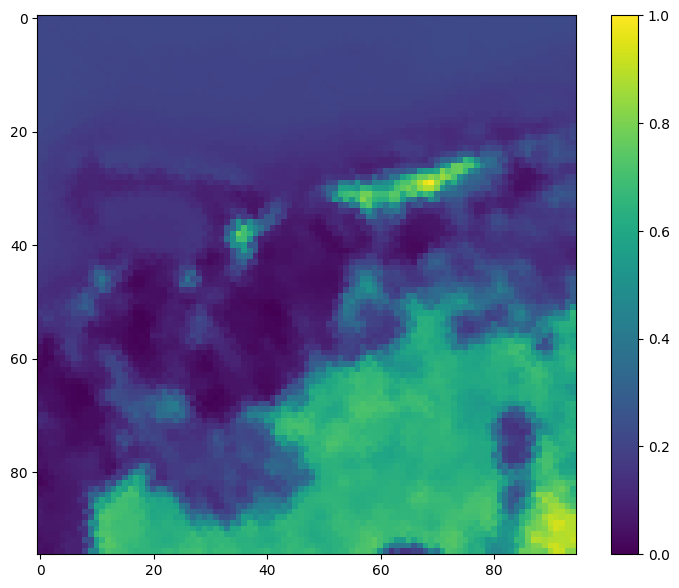

In [4]:
plt.imshow(hyperspectral_cube[:,:,2]);
plt.colorbar();

In [5]:
n_superpixels = 500 #2500
slic_m_param = 2    #2
assignments, centers = superpixel.generate_SLIC_assignments(data = hyperspectral_cube,
                                                            n_superpixels = n_superpixels,
                                                            slic_m_param = slic_m_param)
superpixeled_cube, superpixel_library = superpixel.generate_SLIC_superpixels(data = hyperspectral_cube,
                                                                             assignments = assignments)
n_superpixels = len(np.unique(assignments))

Adjusting n_superpixels: 529
Created 529 superpixels


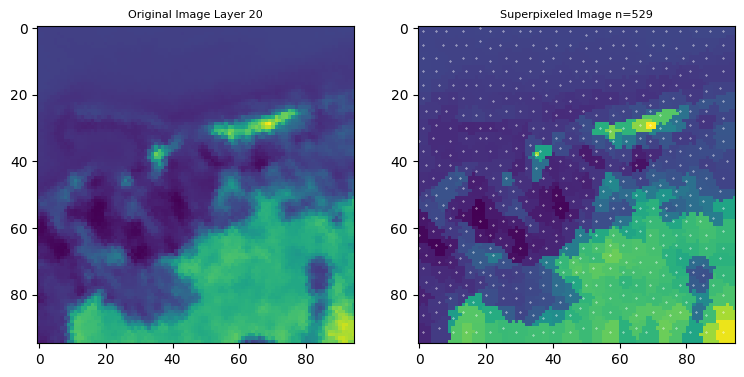

In [10]:
fig, ax = plt.subplots(1,2, dpi=100);
layer_preview = 20
ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
ax[1].imshow(superpixeled_cube[:,:,layer_preview])
ax[1].scatter(centers[:,1], centers[:,0], c='white', s=0.1);
ax[0].set_title(f'Original Image Layer {layer_preview}', fontsize = 8);
ax[1].set_title(f'Superpixeled Image n={len(np.unique(assignments))}', fontsize = 8);

Initial Clustering
Spectral + Unmixing Clustering


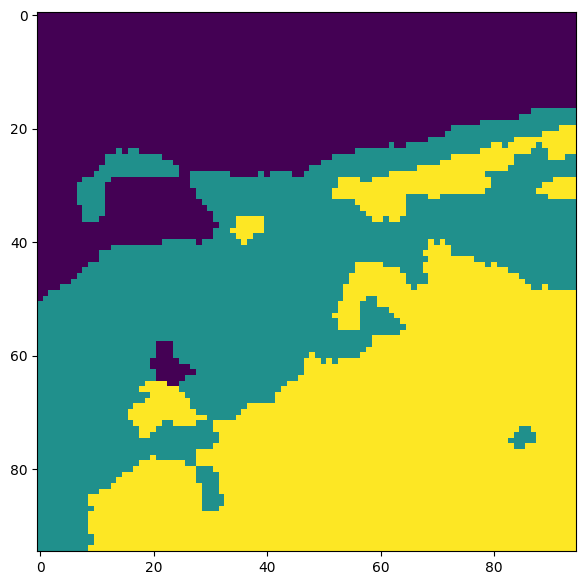

In [11]:
sigma_param = 0.025 # 0.1 -> 0.001           #0.01
spatial_limit = 50# 15 -> 25 in steps of 5 #15
ne = 3#number of endmembers

superpixel_cluster_labels, mean_cluster_spectra = normalized_cuts.single_ncuts_admm(data=hyperspectral_cube,
                                                                                superpixel_library=superpixel_library,
                                                                                superpixel_centers=centers,
                                                                                superpixel_assignments=assignments,
                                                                                n_endmembers=ne,
                                                                                spectral_sigma2_param=sigma_param,
                                                                                spatial_kappa_param=spatial_limit,
                                                                                spectral_metric='SAM')

labelled_img = normalized_cuts.assign_labels_onto_image(assignments, superpixel_cluster_labels)

_, superpixel_original_library = superpixel.generate_SLIC_superpixels(data = original_hyperspectral_cube,
                                                                      assignments = assignments)

original_library = segmentation_evaluation.calc_mean_label_signatures(superpixel_original_library, superpixel_cluster_labels)

plt.imshow(labelled_img);

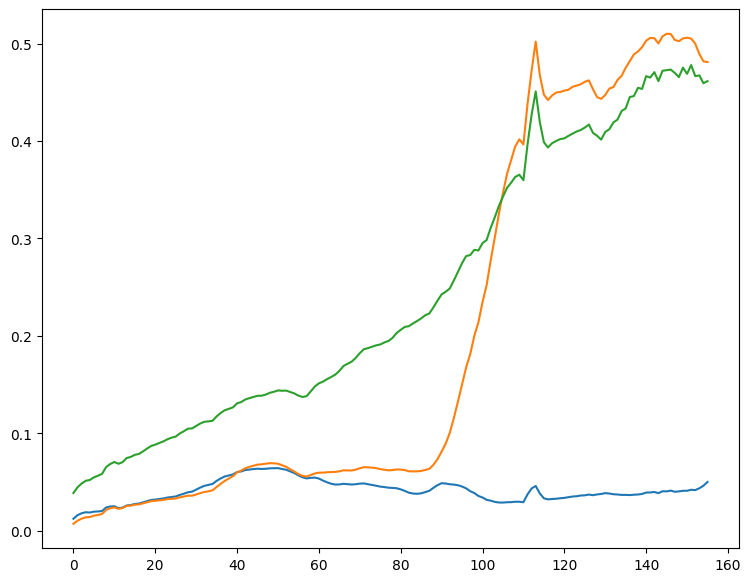

In [12]:
plt.plot(original_library);